In [36]:
import pandas as pd
import numpy as np

defaults = pd.read_csv(
    r"C:\Users\wojte\Desktop\Hacknation2025\data\krz_pkd_short.csv",
    sep=";"
)
defaults["rok"] = pd.to_numeric(defaults["rok"], errors="coerce").astype("Int64")
defaults["pkd"] = defaults["pkd"].astype(str).str.strip()

ratios = pd.read_csv(
    r"C:\Users\wojte\Desktop\Hacknation2025\data\df_ratios_finished_final_8_ratios_jig.csv"
)
ratios["rok"] = pd.to_numeric(ratios["rok"], errors="coerce").astype("Int64")

# --- ogranicz defaulty do lat z ratios
years_ratios = set(ratios["rok"].dropna().unique())
defaults = defaults[defaults["rok"].isin(years_ratios)].copy()

ratio_cols = [c for c in ratios.columns if c != "rok"]

# CASE A: ratios ma 'pkd'
if "pkd" in ratios.columns:
    ratios["pkd"] = ratios["pkd"].astype(str).str.strip()

    merged = ratios.merge(
        defaults,
        on=["rok", "pkd"],
        how="left"
    )

# CASE B: ratios wide z prefiksami PKD
else:
    rat_long = ratios.melt(
        id_vars=["rok"],
        value_vars=ratio_cols,
        var_name="key",
        value_name="value"
    )

    rat_long[["pkd", "ratio_type"]] = rat_long["key"].str.split("_", n=1, expand=True)
    rat_long["pkd"] = rat_long["pkd"].astype(str).str.strip()

    rat_wide = rat_long.pivot_table(
        index=["rok", "pkd"],
        columns="ratio_type",
        values="value",
        aggfunc="mean"
    ).reset_index()

    rat_wide.columns.name = None

    merged = rat_wide.merge(
        defaults,
        on=["rok", "pkd"],
        how="left"
    )

print(merged.head())
print(merged)

    rok   pkd  CF_dyn  CF_to_TC  DEBT_to_GS  GS_dyn  NP_dyn  NP_to_GS  \
0  2005  10.1     NaN  0.048337    0.200806     NaN     NaN  0.019857   
1  2005  22.2     NaN  0.109627    0.320738     NaN     NaN  0.044657   
2  2005  29.3     NaN  0.122344    0.343810     NaN     NaN  0.057006   
3  2005  35.1     NaN  0.116149    0.310608     NaN     NaN  0.034853   
4  2005  41.2     NaN  0.046796    0.343127     NaN     NaN  0.020894   

   NP_to_TC  STL_to_GS  liczba_upadlosci  
0  0.020330   0.133217               NaN  
1  0.047179   0.244635               NaN  
2  0.061128   0.254081               NaN  
3  0.036543   0.157711               NaN  
4  0.021485   0.305324               NaN  
      rok   pkd    CF_dyn  CF_to_TC  DEBT_to_GS    GS_dyn    NP_dyn  NP_to_GS  \
0    2005  10.1       NaN  0.048337    0.200806       NaN       NaN  0.019857   
1    2005  22.2       NaN  0.109627    0.320738       NaN       NaN  0.044657   
2    2005  29.3       NaN  0.122344    0.343810       NaN   

C:\Users\wojte\AppData\Local\Temp\ipykernel_33024\1372619808.py:103: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot_mat = corr_plot_full.applymap(


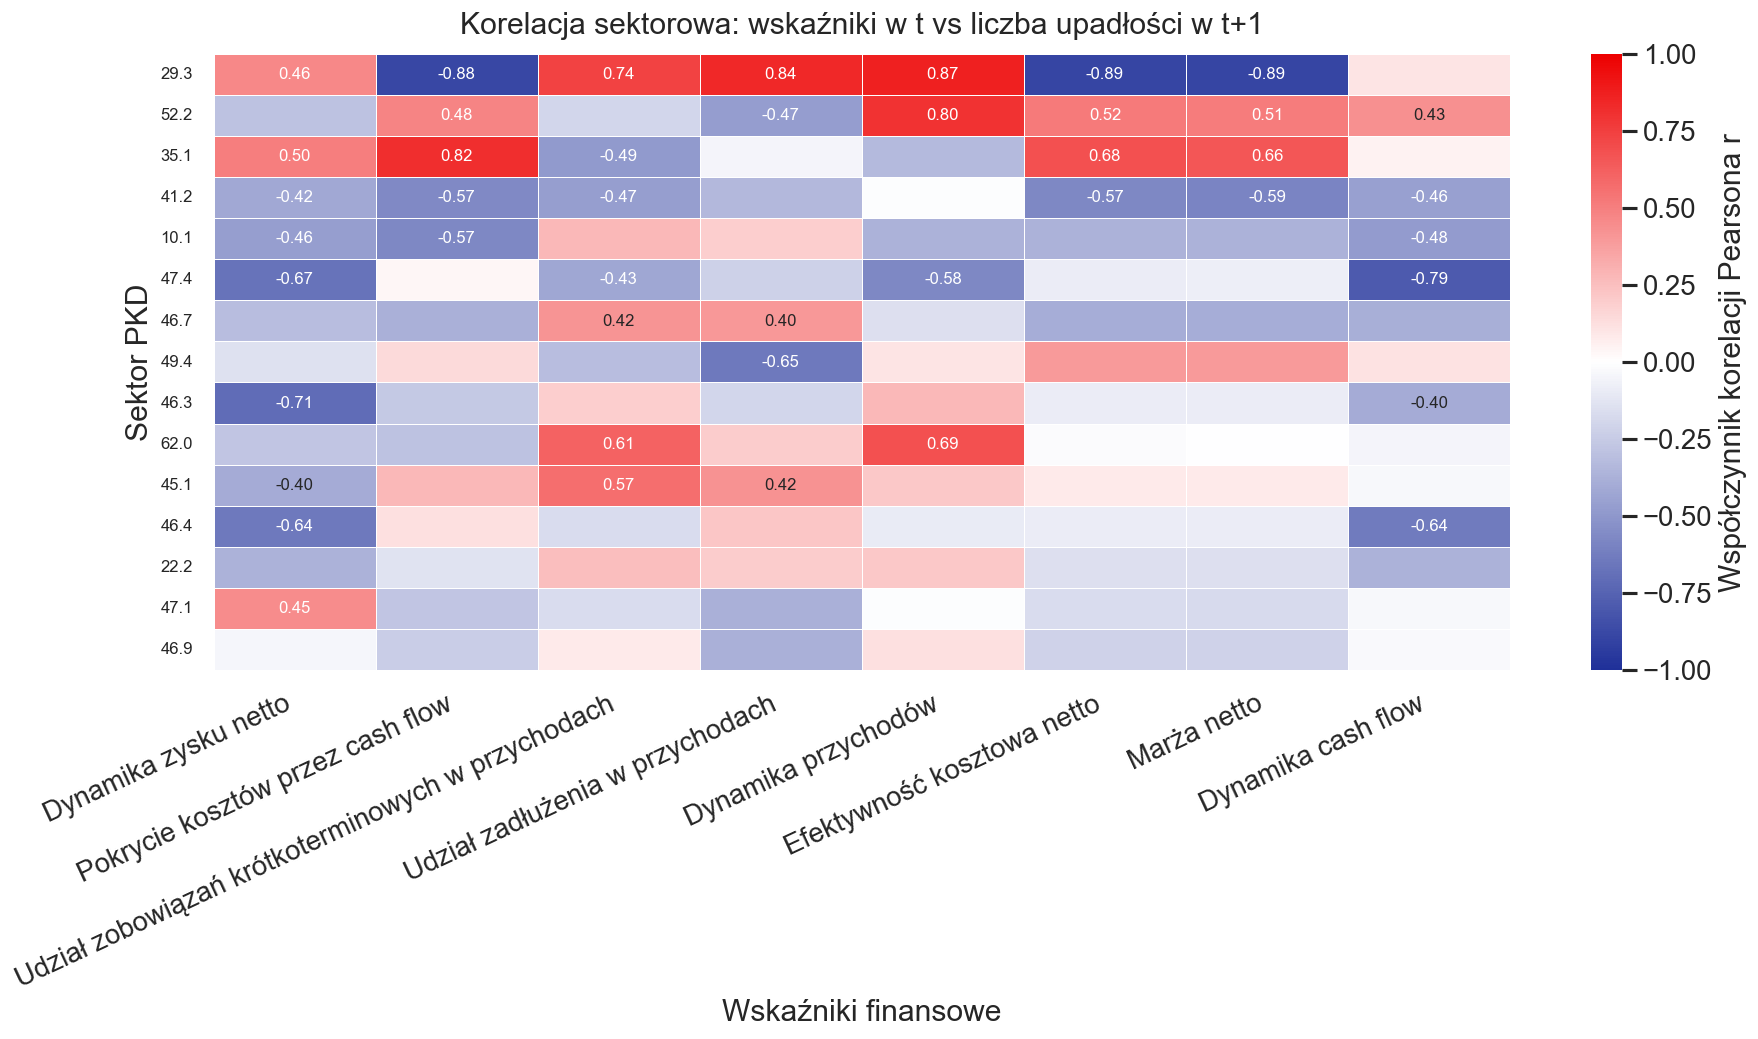

In [37]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# -------------------------------
# 1) Load data
# -------------------------------
defaults = pd.read_csv(
    r"C:\Users\wojte\Desktop\Hacknation2025\data\krz_pkd_short.csv",
    sep=";"
)
ratios = pd.read_csv(
    r"C:\Users\wojte\Desktop\Hacknation2025\data\df_ratios_finished_final_8_ratios_jig.csv"
)

# Basic cleanup
defaults["rok"] = pd.to_numeric(defaults["rok"], errors="coerce")
defaults["pkd"] = defaults["pkd"].astype(str).str.strip()
defaults["liczba_upadlosci"] = pd.to_numeric(defaults["liczba_upadlosci"], errors="coerce")

ratios["rok"] = pd.to_numeric(ratios["rok"], errors="coerce")

# -------------------------------
# 2) Use ONLY years that are in ratios
# -------------------------------
years_ratios = set(ratios["rok"].dropna().unique())
defaults = defaults[defaults["rok"].isin(years_ratios)].copy()

# -------------------------------
# 3) Identify ratio structure (wide with PKD prefixes)
# -------------------------------
ratio_cols = [c for c in ratios.columns if c != "rok"]
prefixes = sorted({c.split("_", 1)[0] for c in ratio_cols})
ratio_types = sorted({c.split("_", 1)[1] for c in ratio_cols})

# -------------------------------
# 4) Build corr_plot:
#    correlation of ratios at t vs bankruptcies at t+1, sector-wise
# -------------------------------
corr_plot = pd.DataFrame(index=prefixes, columns=ratio_types, dtype=float)

for prefix in prefixes:
    cols = [c for c in ratio_cols if c.startswith(prefix + "_")]
    if not cols:
        continue

    # defaults for this PKD
    d = defaults[defaults["pkd"] == prefix][["rok", "liczba_upadlosci"]].copy()
    if d.empty:
        continue

    # merge ratios for this PKD with its defaults
    tmp = ratios[["rok"] + cols].merge(d, on="rok", how="left")

    # ensure time order
    tmp = tmp.sort_values("rok")

    # target at t+1
    tmp["upadlosci_t1"] = tmp["liczba_upadlosci"].shift(-1)

    # compute correlation
    df = tmp[["upadlosci_t1"] + cols].dropna()
    if df.empty:
        continue

    corr = df.corr(numeric_only=True)["upadlosci_t1"].drop("upadlosci_t1")

    for full, val in corr.items():
        corr_plot.at[prefix, full.split("_", 1)[1]] = val

# -------------------------------
# 5) Pretty Polish labels
# -------------------------------
threshold = 0.4

pretty_pl = {
    "DEBT_to_GS": "Udział zadłużenia w przychodach",
    "CF_to_TC": "Pokrycie kosztów przez cash flow",
    "STL_to_GS": "Udział zobowiązań krótkoterminowych w przychodach",
    "NP_to_TC": "Efektywność kosztowa netto",
    "NP_to_GS": "Marża netto",
    "GS_dyn": "Dynamika przychodów",
    "CF_dyn": "Dynamika cash flow",
    "NP_dyn": "Dynamika zysku netto",
}

# -------------------------------
# 6) Order rows/cols by mean |corr|
# -------------------------------
row_order = corr_plot.abs().mean(axis=1).sort_values(ascending=False).index
col_order = corr_plot.abs().mean(axis=0).sort_values(ascending=False).index
corr_plot_ord = corr_plot.loc[row_order, col_order]

# Rename columns for plotting only
corr_plot_full = corr_plot_ord.rename(columns=lambda c: pretty_pl.get(c, c))

# Mask NaNs
mask = corr_plot_full.isna()

# Thresholded annotations
annot_mat = corr_plot_full.applymap(
    lambda x: f"{x:.2f}" if pd.notna(x) and abs(x) >= threshold else ""
)

# -------------------------------
# 7) Custom blue-white-red gradient
# -------------------------------
blue_white_red = LinearSegmentedColormap.from_list(
    "blue_white_red",
    ["#1f3099", "#ffffff", "#ed0000"]
)

# -------------------------------
# 8) Plot
# -------------------------------
sns.set_theme(style="white", context="talk")

fig, ax = plt.subplots(figsize=(16, 9), dpi=120)

sns.heatmap(
    corr_plot_full,
    mask=mask,
    annot=annot_mat,
    fmt="",
    cmap=blue_white_red,
    center=0,
    vmin=-1, vmax=1,
    linewidths=0.6,
    linecolor="white",
    cbar_kws={"label": "Współczynnik korelacji Pearsona r"},
    annot_kws={"size": 10},
    ax=ax
)

ax.set_title("Korelacja sektorowa: wskaźniki w t vs liczba upadłości w t+1", pad=12)
ax.set_xlabel("Wskaźniki finansowe")
ax.set_ylabel("Sektor PKD")

plt.xticks(rotation=25, ha="right")
plt.yticks(rotation=0, fontsize=10)

plt.tight_layout()
plt.savefig(
    "corr_heatmap_upadlosci_t1_thresholded.png",
    dpi=300, bbox_inches="tight", facecolor="white"
)
plt.show()


C:\Users\wojte\AppData\Local\Temp\ipykernel_33024\2857836212.py:70: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot_mat = corr_plot_full.applymap(


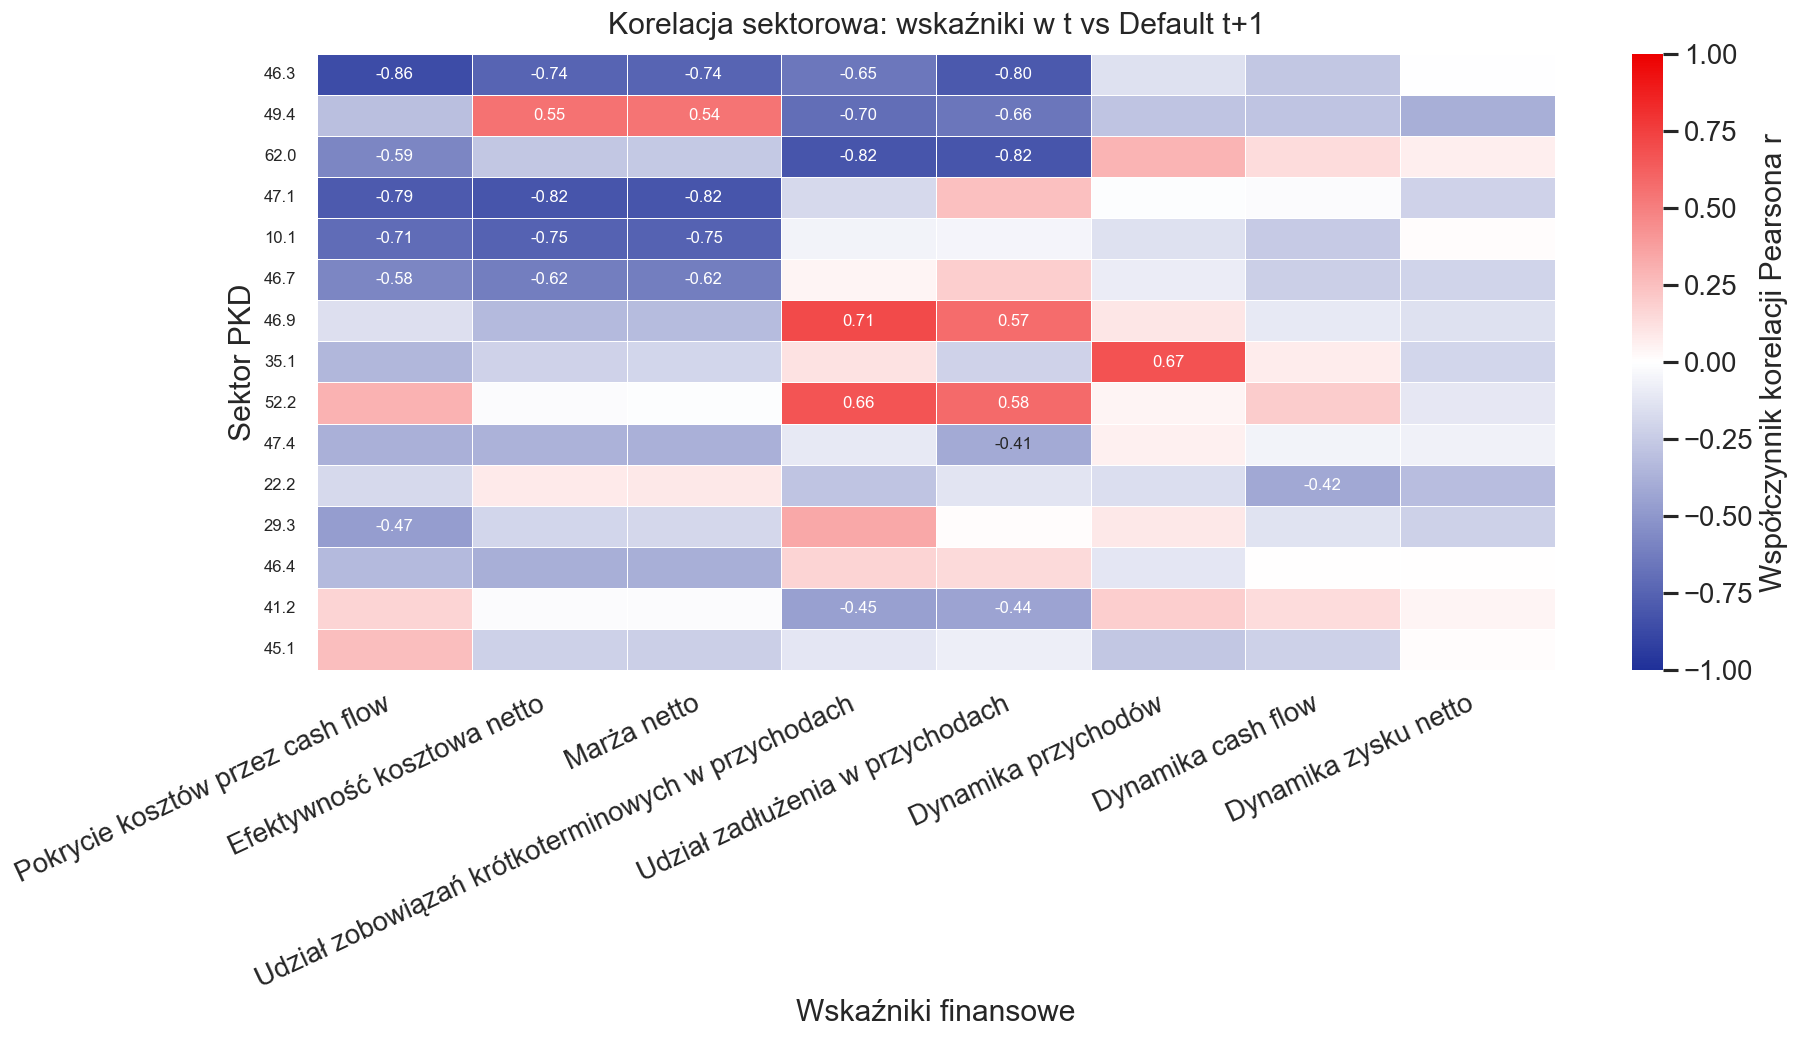

In [32]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# -------------------------------
# 1) Load data
# -------------------------------
nums = pd.read_csv(r"C:\Users\wojte\Desktop\Hacknation2025\data\df_pivot_filtered_numbers.csv")
ratios = pd.read_csv(r"C:\Users\wojte\Desktop\Hacknation2025\data\df_ratios_finished_final_8_ratios_jig.csv")

# -------------------------------
# 2) Build corr_plot:
#    correlation of ratios at t vs EN at t+1, sector-wise
# -------------------------------
ratio_cols = [c for c in ratios.columns if c != "rok"]
prefixes = sorted({c.split("_", 1)[0] for c in ratio_cols})
ratio_types = sorted({c.split("_", 1)[1] for c in ratio_cols})

corr_plot = pd.DataFrame(index=prefixes, columns=ratio_types, dtype=float)

for prefix in prefixes:
    en_col = f"{prefix}_EN"
    if en_col not in nums.columns:
        continue

    en_t1 = nums[en_col].shift(-1)  # EN at t+1
    cols = [c for c in ratio_cols if c.startswith(prefix + "_")]

    df = pd.concat([en_t1.rename("EN_t1"), ratios[cols]], axis=1).dropna()
    if df.empty:
        continue

    corr = df.corr(numeric_only=True)["EN_t1"].drop("EN_t1")

    for full, val in corr.items():
        corr_plot.at[prefix, full.split("_", 1)[1]] = val

# -------------------------------
# 3) Pretty Polish labels
# -------------------------------
threshold = 0.4

pretty_pl = {
    "DEBT_to_GS": "Udział zadłużenia w przychodach",
    "CF_to_TC": "Pokrycie kosztów przez cash flow",
    "STL_to_GS": "Udział zobowiązań krótkoterminowych w przychodach",
    "NP_to_TC": "Efektywność kosztowa netto",
    "NP_to_GS": "Marża netto",
    "GS_dyn": "Dynamika przychodów",
    "CF_dyn": "Dynamika cash flow",
    "NP_dyn": "Dynamika zysku netto",
}

# -------------------------------
# 4) Order rows/cols by mean |corr|
# -------------------------------
row_order = corr_plot.abs().mean(axis=1).sort_values(ascending=False).index
col_order = corr_plot.abs().mean(axis=0).sort_values(ascending=False).index
corr_plot_ord = corr_plot.loc[row_order, col_order]

# Rename columns for plotting only
corr_plot_full = corr_plot_ord.rename(columns=lambda c: pretty_pl.get(c, c))

# Mask NaNs
mask = corr_plot_full.isna()

# Thresholded annotations
annot_mat = corr_plot_full.applymap(
    lambda x: f"{x:.2f}" if pd.notna(x) and abs(x) >= threshold else ""
)

# -------------------------------
# 5) Custom blue-white-red gradient
# -------------------------------
blue_white_red = LinearSegmentedColormap.from_list(
    "blue_white_red",
    ["#1f3099", "#ffffff", "#ed0000"]  # deep blue → white → deep red
)

# -------------------------------
# 6) Plot
# -------------------------------
sns.set_theme(style="white", context="talk")

fig, ax = plt.subplots(figsize=(16, 9), dpi=120)

sns.heatmap(
    corr_plot_full,
    mask=mask,
    annot=annot_mat,
    fmt="",
    cmap=blue_white_red,
    center=0,
    vmin=-1, vmax=1,
    linewidths=0.6,
    linecolor="white",
    cbar_kws={"label": "Współczynnik korelacji Pearsona r"},
    annot_kws={"size": 10},
    ax=ax
)

ax.set_title("Korelacja sektorowa: wskaźniki w t vs Default t+1", pad=12)
ax.set_xlabel("Wskaźniki finansowe")
ax.set_ylabel("Sektor PKD")

plt.xticks(rotation=25, ha="right")
plt.yticks(rotation=0, fontsize=10)

plt.tight_layout()
plt.savefig(
    "corr_heatmap_EN_t1_thresholded_full_labels.png",
    dpi=300, bbox_inches="tight", facecolor="white"
)
plt.show()


In [7]:
import pandas as pd
import numpy as np

nums = pd.read_csv(r"C:\Users\wojte\Desktop\Hacknation2025\data\df_pivot_filtered_numbers.csv")
ratios = pd.read_csv(r"C:\Users\wojte\Desktop\Hacknation2025\data\df_ratios_finished_final_8_ratios_jig.csv")

# --- Identify columns ---
ratio_cols = [c for c in ratios.columns if c != "rok"]
en_cols = [c for c in nums.columns if c.endswith("_EN")]

# --- Make sure both frames align by year ---
# If both have 'rok', we merge on it. Otherwise we align by row order (like your original code).
if "rok" in nums.columns and "rok" in ratios.columns:
    base = pd.merge(nums[["rok"] + en_cols], ratios[["rok"] + ratio_cols], on="rok", how="inner")
else:
    base = pd.concat([nums[en_cols].copy(), ratios[ratio_cols].copy()], axis=1).reset_index(drop=True)
    base["rok"] = np.arange(len(base))  # fallback index-as-year

# --- Build long EN ---
en_long = base.melt(
    id_vars=["rok"],
    value_vars=en_cols,
    var_name="sector",
    value_name="EN"
)
en_long["sector"] = en_long["sector"].str.replace("_EN", "", regex=False)

# --- Build long ratios ---
rat_long = base.melt(
    id_vars=["rok"],
    value_vars=ratio_cols,
    var_name="key",
    value_name="ratio"
)
rat_long[["sector", "ratio_type"]] = rat_long["key"].str.split("_", n=1, expand=True)
rat_long = rat_long.drop(columns=["key"])

# --- Merge ---
long = pd.merge(rat_long, en_long, on=["rok", "sector"], how="inner")

# --- Option A: same-year cross-sectional correlation ---
def cs_corr_same_year(df):
    # correlation across sectors within a year
    return df["ratio"].corr(df["EN"])

cs = (
    long.groupby(["rok", "ratio_type"])
        .apply(cs_corr_same_year)
        .rename("cs_corr")
        .reset_index()
)

cs_summary = (
    cs.groupby("ratio_type")["cs_corr"]
      .agg(["mean", "median", "count"])
      .sort_values("mean")
)

print(cs_summary)


                mean    median  count
ratio_type                           
DEBT_to_GS -0.357988 -0.372279     20
CF_to_TC   -0.332167 -0.348677     20
STL_to_GS  -0.241659 -0.255724     20
NP_to_TC   -0.098620 -0.202127     20
NP_to_GS   -0.093041 -0.192848     20
GS_dyn     -0.061535 -0.035923     19
CF_dyn     -0.057493  0.085639     19
NP_dyn      0.079508  0.103476     19


C:\Users\wojte\AppData\Local\Temp\ipykernel_33024\3621696562.py:48: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(cs_corr_same_year)


C:\Users\wojte\AppData\Local\Temp\ipykernel_33024\2972648457.py:75: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(cs_corr_t1)


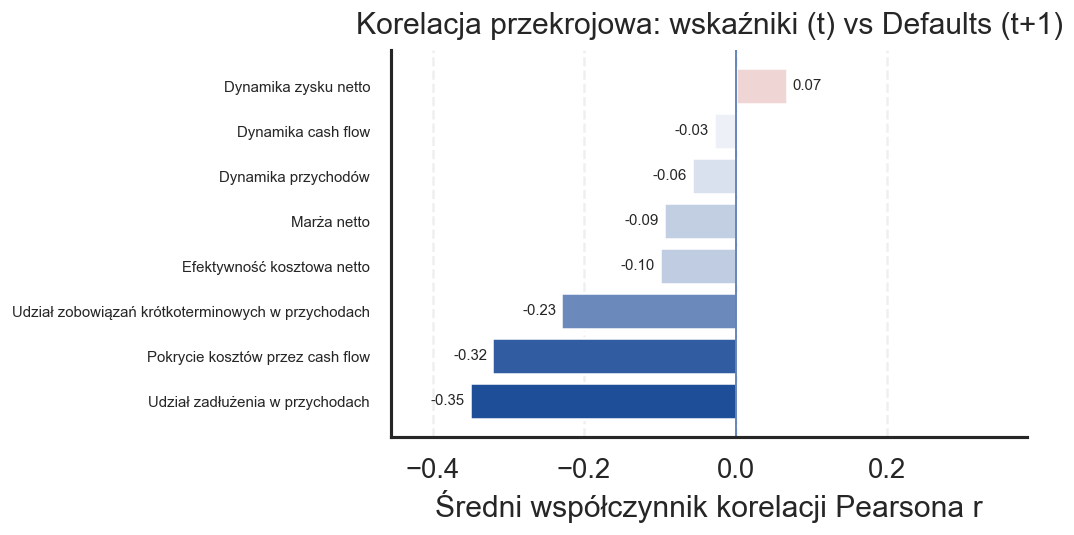

                mean    median  count
ratio_type                           
DEBT_to_GS -0.350183 -0.367987     19
CF_to_TC   -0.321175 -0.390657     19
STL_to_GS  -0.229871 -0.243886     19
NP_to_TC   -0.099729 -0.265505     19
NP_to_GS   -0.094161 -0.248664     19
GS_dyn     -0.058070 -0.041075     18
CF_dyn     -0.029002  0.089813     18
NP_dyn      0.067533  0.115256     18


In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, Normalize

# ----------------------------
# 1) Load data
# ----------------------------
nums = pd.read_csv(r"C:\Users\wojte\Desktop\Hacknation2025\data\df_pivot_filtered_numbers.csv")
ratios = pd.read_csv(r"C:\Users\wojte\Desktop\Hacknation2025\data\df_ratios_finished_final_8_ratios_jig.csv")

# Identify columns
ratio_cols = [c for c in ratios.columns if c != "rok"]
en_cols = [c for c in nums.columns if c.endswith("_EN")]

# ----------------------------
# 2) Align by year if possible
# ----------------------------
if "rok" in nums.columns and "rok" in ratios.columns:
    base = pd.merge(nums[["rok"] + en_cols], ratios[["rok"] + ratio_cols], on="rok", how="inner")
else:
    # fallback: assume same row order
    base = pd.concat([nums[en_cols].copy(), ratios[ratio_cols].copy()], axis=1).reset_index(drop=True)
    base["rok"] = np.arange(len(base))

# ----------------------------
# 3) Wide -> long
# ----------------------------
# EN long
en_long = base.melt(
    id_vars=["rok"],
    value_vars=en_cols,
    var_name="sector",
    value_name="EN"
)
en_long["sector"] = en_long["sector"].str.replace("_EN", "", regex=False)

# Ratios long
rat_long = base.melt(
    id_vars=["rok"],
    value_vars=ratio_cols,
    var_name="key",
    value_name="ratio"
)
rat_long[["sector", "ratio_type"]] = rat_long["key"].str.split("_", n=1, expand=True)
rat_long = rat_long.drop(columns=["key"])

# ----------------------------
# 4) Build EN(t+1) per sector
# ----------------------------
en_long = en_long.sort_values(["sector", "rok"]).copy()
en_long["EN_t1"] = en_long.groupby("sector")["EN"].shift(-1)

# Merge ratios(t) with EN(t+1)
long_t1 = pd.merge(
    rat_long,
    en_long[["rok", "sector", "EN_t1"]],
    on=["rok", "sector"],
    how="inner"
).dropna()

# ----------------------------
# 5) Cross-sectional correlation
#    For each year & ratio_type:
#    corr across sectors of ratio(t) vs EN(t+1)
# ----------------------------
def cs_corr_t1(df):
    # Needs at least 2 points to compute corr
    if df["ratio"].nunique() < 2 or df["EN_t1"].nunique() < 2:
        return np.nan
    return df["ratio"].corr(df["EN_t1"])

cs_t1 = (
    long_t1.groupby(["rok", "ratio_type"])
           .apply(cs_corr_t1)
           .rename("cs_corr_t1")
           .reset_index()
)

# Summary:
cs_t1_summary = (
    cs_t1.groupby("ratio_type")["cs_corr_t1"]
         .agg(mean="mean", median="median", count="count")
         .sort_values("mean")
)

# ----------------------------
# 6) Polish names for plotting
# ----------------------------
pretty_pl = {
    "DEBT_to_GS": "Udział zadłużenia w przychodach",
    "CF_to_TC": "Pokrycie kosztów przez cash flow",
    "STL_to_GS": "Udział zobowiązań krótkoterminowych w przychodach",
    "NP_to_TC": "Efektywność kosztowa netto",
    "NP_to_GS": "Marża netto",
    "GS_dyn": "Dynamika przychodów",
    "CF_dyn": "Dynamika cash flow",
    "NP_dyn": "Dynamika zysku netto",
}

vals = cs_t1_summary["mean"].sort_values()
vals_plot = vals.rename(index=lambda x: pretty_pl.get(x, x))

# ----------------------------
# 7) Blue -> white -> red gradient for bars
# ----------------------------
blue_white_red = LinearSegmentedColormap.from_list(
    "blue_white_red",
    ["#1f4e99", "#ffffff", "#b22222"]
)

mx = np.nanmax(np.abs(vals_plot.values)) if len(vals_plot) else 1.0
norm = Normalize(vmin=-mx, vmax=mx)
colors = blue_white_red(norm(vals_plot.values))

# ----------------------------
# 8) Plot
# ----------------------------
fig, ax = plt.subplots(figsize=(9, 4.8), dpi=120)

bars = ax.barh(vals_plot.index, vals_plot.values, color=colors)

ax.axvline(0, linewidth=1)
ax.xaxis.grid(True, linestyle="--", alpha=0.3)
ax.set_axisbelow(True)

ax.set_title("Korelacja przekrojowa: wskaźniki (t) vs Defaults (t+1)", pad=10)
ax.set_xlabel("Średni współczynnik korelacji Pearsona r")
ax.set_ylabel("")

ax.set_xlim(-1.3 * mx, 1.1 * mx)

# Value labels
for b in bars:
    w = b.get_width()
    ax.text(
        w + (0.02 * mx if w >= 0 else -0.02 * mx),
        b.get_y() + b.get_height() / 2,
        f"{w:.2f}",
        va="center",
        ha="left" if w >= 0 else "right",
        fontsize=9
    )

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
bars = ax.barh(vals_plot.index, vals_plot.values, color=colors)

ax.tick_params(axis="y", labelsize=9)

# ...reszta bez zmian

plt.tight_layout()
plt.savefig("mean_cs_corr_ratio_vs_EN_t1_h.png", dpi=300, bbox_inches="tight", facecolor="white")
plt.show()

# ----------------------------
# 9) (Optional) quick check output
# ----------------------------
print(cs_t1_summary)


# nie usuwajcie plota bo usunalem dependency :)

C:\Users\wojte\AppData\Local\Temp\ipykernel_33024\232707579.py:78: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(cs_corr_t1)


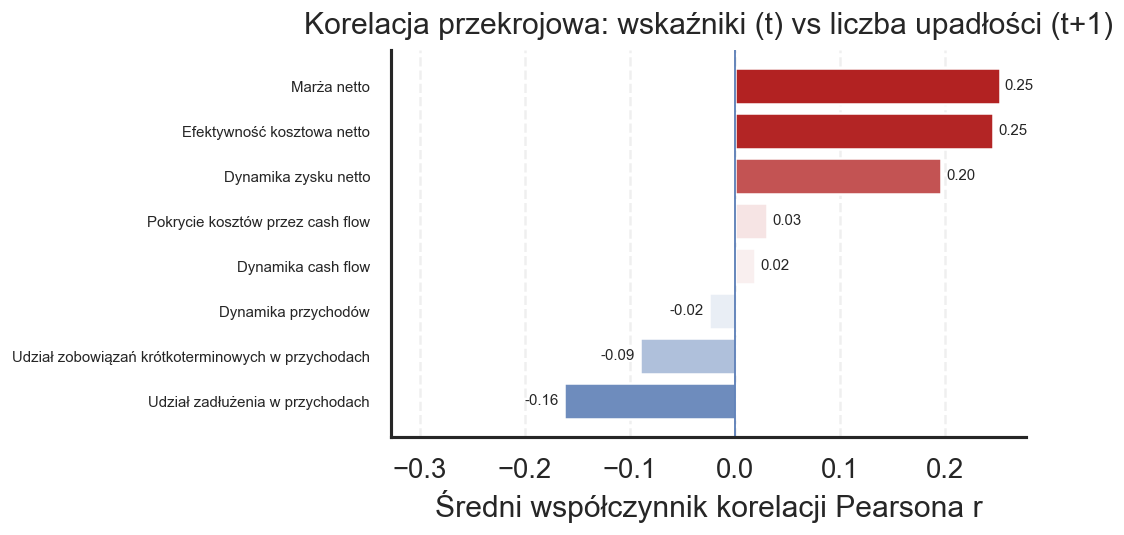

                mean    median  count
ratio_type                           
DEBT_to_GS -0.162623 -0.146377      6
STL_to_GS  -0.090419 -0.095341      6
GS_dyn     -0.024626 -0.097359      6
CF_dyn      0.019659 -0.012742      6
CF_to_TC    0.030686  0.080000      6
NP_dyn      0.196268  0.206819      6
NP_to_TC    0.246330  0.254679      6
NP_to_GS    0.252184  0.258012      6


In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, Normalize

# ----------------------------
# 1) Load data
# ----------------------------
defaults = pd.read_csv(
    r"C:\Users\wojte\Desktop\Hacknation2025\data\krz_pkd_short.csv",
    sep=";"
)
ratios = pd.read_csv(
    r"C:\Users\wojte\Desktop\Hacknation2025\data\df_ratios_finished_final_8_ratios_jig.csv"
)

# ----------------------------
# 2) Cleanup types
# ----------------------------
defaults["rok"] = pd.to_numeric(defaults["rok"], errors="coerce")
defaults["pkd"] = defaults["pkd"].astype(str).str.strip()
defaults["liczba_upadlosci"] = pd.to_numeric(defaults["liczba_upadlosci"], errors="coerce")

ratios["rok"] = pd.to_numeric(ratios["rok"], errors="coerce")

# ----------------------------
# 3) Use ONLY years that are in ratios (as you wanted earlier)
# ----------------------------
years_ratios = set(ratios["rok"].dropna().unique())
defaults = defaults[defaults["rok"].isin(years_ratios)].copy()

# ----------------------------
# 4) Build bankruptcies(t+1) per PKD
# ----------------------------
defaults = defaults.sort_values(["pkd", "rok"]).copy()
defaults["upadlosci_t1"] = defaults.groupby("pkd")["liczba_upadlosci"].shift(-1)

# ----------------------------
# 5) Ratios wide -> long
#    columns like: "10.1_NP_to_GS"
# ----------------------------
ratio_cols = [c for c in ratios.columns if c != "rok"]

rat_long = ratios.melt(
    id_vars=["rok"],
    value_vars=ratio_cols,
    var_name="key",
    value_name="ratio"
)

rat_long[["pkd", "ratio_type"]] = rat_long["key"].str.split("_", n=1, expand=True)
rat_long["pkd"] = rat_long["pkd"].astype(str).str.strip()
rat_long = rat_long.drop(columns=["key"])

# ----------------------------
# 6) Merge ratios(t) with upadlosci(t+1)
#    Base: ratios (PKD + lata z ratios)
# ----------------------------
long_t1 = pd.merge(
    rat_long,
    defaults[["rok", "pkd", "upadlosci_t1"]],
    on=["rok", "pkd"],
    how="left"
).dropna(subset=["ratio", "upadlosci_t1"])

# ----------------------------
# 7) Cross-sectional correlation
#    For each year & ratio_type:
#    corr across PKD of ratio(t) vs upadlosci(t+1)
# ----------------------------
def cs_corr_t1(df):
    if df["ratio"].nunique() < 2 or df["upadlosci_t1"].nunique() < 2:
        return np.nan
    return df["ratio"].corr(df["upadlosci_t1"])

cs_t1 = (
    long_t1.groupby(["rok", "ratio_type"])
           .apply(cs_corr_t1)
           .rename("cs_corr_t1")
           .reset_index()
)

cs_t1_summary = (
    cs_t1.groupby("ratio_type")["cs_corr_t1"]
         .agg(mean="mean", median="median", count="count")
         .sort_values("mean")
)

# ----------------------------
# 8) Polish names for plotting
# ----------------------------
pretty_pl = {
    "DEBT_to_GS": "Udział zadłużenia w przychodach",
    "CF_to_TC": "Pokrycie kosztów przez cash flow",
    "STL_to_GS": "Udział zobowiązań krótkoterminowych w przychodach",
    "NP_to_TC": "Efektywność kosztowa netto",
    "NP_to_GS": "Marża netto",
    "GS_dyn": "Dynamika przychodów",
    "CF_dyn": "Dynamika cash flow",
    "NP_dyn": "Dynamika zysku netto",
}

vals = cs_t1_summary["mean"].sort_values()
vals_plot = vals.rename(index=lambda x: pretty_pl.get(x, x))

# ----------------------------
# 9) Blue -> white -> red gradient for bars
# ----------------------------
blue_white_red = LinearSegmentedColormap.from_list(
    "blue_white_red",
    ["#1f4e99", "#ffffff", "#b22222"]
)

mx = np.nanmax(np.abs(vals_plot.values)) if len(vals_plot) else 1.0
norm = Normalize(vmin=-mx, vmax=mx)
colors = blue_white_red(norm(vals_plot.values))

# ----------------------------
# 10) Plot
# ----------------------------
fig, ax = plt.subplots(figsize=(9, 4.8), dpi=120)

bars = ax.barh(vals_plot.index, vals_plot.values, color=colors)

ax.axvline(0, linewidth=1)
ax.xaxis.grid(True, linestyle="--", alpha=0.3)
ax.set_axisbelow(True)

ax.set_title("Korelacja przekrojowa: wskaźniki (t) vs liczba upadłości (t+1)", pad=10)
ax.set_xlabel("Średni współczynnik korelacji Pearsona r")
ax.set_ylabel("")

ax.set_xlim(-1.3 * mx, 1.1 * mx)

# Smaller font for ratio names (your request)
ax.tick_params(axis="y", labelsize=9)

# Value labels
for b in bars:
    w = b.get_width()
    ax.text(
        w + (0.02 * mx if w >= 0 else -0.02 * mx),
        b.get_y() + b.get_height() / 2,
        f"{w:.2f}",
        va="center",
        ha="left" if w >= 0 else "right",
        fontsize=9
    )

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.savefig("mean_cs_corr_ratio_vs_upadlosci_t1_h.png", dpi=300, bbox_inches="tight", facecolor="white")
plt.show()

print(cs_t1_summary)
